In [157]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from mvo_utils_v3 import *
from workspace import OptWorkspace

In [159]:
import os, re
import pandas as pd
excel_files = !ls {OptWorkspace.COMPONENT_PATH}*.xlsx
sectors = [re.search(r'(\w+).xlsx', f).group(1) for f in excel_files]
for s in sectors:
    pattern = 'holdings-vg-'
    fname = OptWorkspace.COMPONENT_PATH + pattern + s 
    df = pd.read_excel(fname + '.xlsx', sheet_name='Worksheet', index_col='Identifier')
    mask = (df.index != 'USD') & df.index.notna(); df = df[mask]
    csv_name = fname + '.csv'; df.to_csv(csv_name)
    print("Saved: " + csv_name)

Saved: ./components/holdings-vg-vaw.csv
Saved: ./components/holdings-vg-vcr.csv
Saved: ./components/holdings-vg-vdc.csv
Saved: ./components/holdings-vg-vde.csv
Saved: ./components/holdings-vg-vfh.csv
Saved: ./components/holdings-vg-vgt.csv
Saved: ./components/holdings-vg-vht.csv
Saved: ./components/holdings-vg-vis.csv
Saved: ./components/holdings-vg-vnq.csv
Saved: ./components/holdings-vg-vox.csv
Saved: ./components/holdings-vg-vpu.csv


In [160]:
opt_env = OptWorkspace(10, 1, 1, 0.0, 0.05, universe='vanguard-sectors')
opt_env.refreshPricing = False
opt_env.print_global_vars()

Global Variables
Refresh Pricing: False
Historical Time Window: 60
Lookback: 10
Rebalance Frequency: W-Sat
Net Exposure: 1
Leverage: 1
Weights: min 0.0 to max 0.05
Universe: vanguard-sectors



In [161]:
if opt_env.refreshPricing:
    opt_env.load_companies()
    opt_env.refresh_sector_px();
    opt_env.refresh_component_px(); # not necessary for asset classes
    opt_env.get_pricing('SPY.csv', ['SPY']);

In [162]:
opt_env.load_companies()
remove_tickers = ['CCC', 'LGF/A', 'LGF/B', 'JW/A', 'BF/B', 'BRK/B', 'CRD/B', 'FFH', 'HEI/A', 'MOG/A', 'FCE/A', 'NYLD/A', 'CSRA', 'DPS', 'UAA', 'DISCK', 'JUNO', 'XL', 'WELL', 'BKNG', 'SNI','EVGN', 'CBRE','BF.b','BRK.b']
opt_env.drop_companies(remove_tickers)
tickers = opt_env.companies.index.tolist()
print(len(tickers), "companies left for analysis")

Companies loaded: (2488, 3)
2467 companies left for analysis


In [163]:
px_etfs = opt_env.load_px()
consol_px = opt_env.load_universe_px()[tickers]

Loaded pricing for vanguard-sectors.csv, with shape (42, 11)
Loaded pricing for vaw-hold-pricing.csv, with shape (42, 118)
Loaded pricing for vcr-hold-pricing.csv, with shape (42, 365)
Loaded pricing for vdc-hold-pricing.csv, with shape (42, 98)
Loaded pricing for vde-hold-pricing.csv, with shape (42, 142)
Loaded pricing for vfh-hold-pricing.csv, with shape (42, 401)
Loaded pricing for vgt-hold-pricing.csv, with shape (42, 362)
Loaded pricing for vht-hold-pricing.csv, with shape (42, 367)
Loaded pricing for vis-hold-pricing.csv, with shape (42, 343)
Loaded pricing for vnq-hold-pricing.csv, with shape (42, 182)
Loaded pricing for vox-hold-pricing.csv, with shape (42, 23)
Loaded pricing for vpu-hold-pricing.csv, with shape (42, 75)


In [164]:
px_etfs = opt_env.load_px()
px_spy = opt_env.load_px('SPY.csv')

Loaded pricing for vanguard-sectors.csv, with shape (42, 11)
Loaded pricing for SPY.csv, with shape (42, 1)


In [165]:
# calculates optimal gamma
gamma_val, gamma_sr = opt_env.quick_gamma(opt_env.gammaVals, consol_px)
gamma_val, gamma_sr

(199.52623149688787, 144.96503012196104)

In [166]:
# run portfolio with best net exposure
px_portion, returns, alloc, pdf = opt_env.ls_recommend_allocs(consol_px, gamma_val)
alloc = filter_ls(alloc, 0.01)
recommend = alloc.copy()
tickers = recommend.index.tolist()
companies = opt_env.companies
cos_no_dup = companies.drop_duplicates(subset='Company')
recommend['Sector'] = cos_no_dup.loc[tickers]['ETF']
recommend['Company'] = cos_no_dup.loc[tickers][['Company']]
# recommend = recommend.astype({"Allocation": np.float})
recommend[['Company', 'Sector', 'Allocation']]
recommend

,Allocation,Sector,Company
AMC,0.041608,vcr,AMC ENTERTAINMENT HLDS-CL A
BJRI,0.050000,vcr,BJ'S RESTAURANTS INC
EXPR,0.050000,vcr,EXPRESS INC
FTD,0.050000,vcr,FTD COS INC
SEAS,0.050000,vcr,SEAWORLD ENTERTAINMENT INC
BGS,0.050000,vdc,B&G FOODS INC
FRPT,0.050000,vdc,FRESHPET INC
PSMT,0.050000,vdc,PRICESMART INC
SVU,0.050000,vdc,SUPERVALU INC
CKH,0.050000,vde,SEACOR HOLDINGS INC


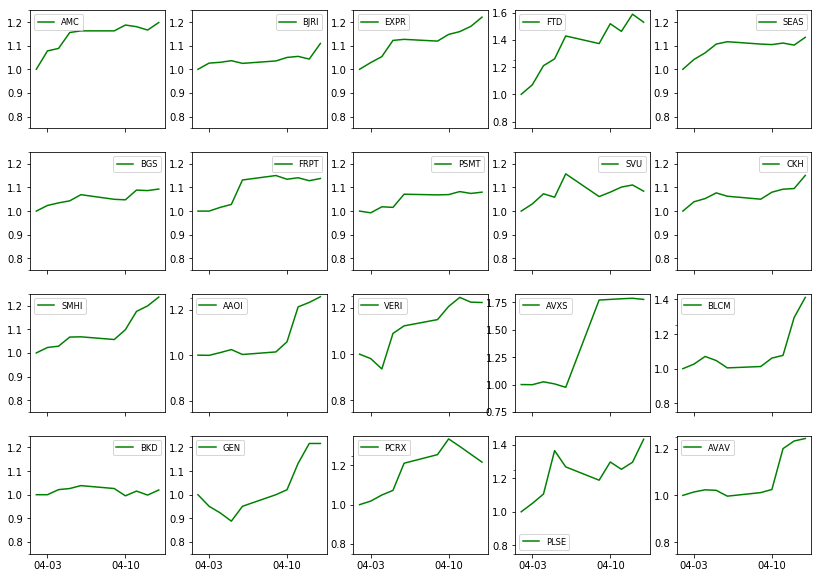

In [167]:
plot_chart_grid(consol_px, recommend, 'Allocation', opt_env.lookback, tickers)

In [168]:
sect_group_stats(recommend, 'Sector').sort_values(by='Sector Weight', ascending=False).round(2)

Total % Allocation 98.00


,Sector Weight,Avg Position
vht,0.26,0.04
vcr,0.24,0.05
vdc,0.20,0.05
vis,0.10,0.05
vde,0.10,0.05
vnq,0.05,0.05
vgt,0.03,0.01


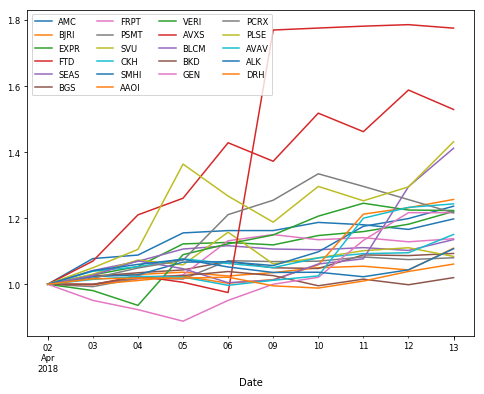

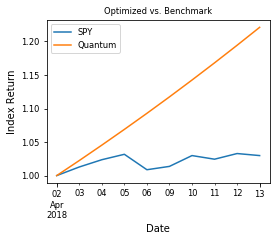

In [169]:
port_pos_idx = compound(consol_px[-opt_env.lookback:][recommend.index])
ax = port_pos_idx.plot(fontsize='small', figsize=(8,6))
ax.legend(fontsize='small', ncol=4)
idx_px_spy = compound(px_spy.loc[port_pos_idx.index])
plot_two_series(idx_px_spy, pdf, 'SPY', 'Quantum', 'Date', 'Index Return', 'Optimized vs. Benchmark')

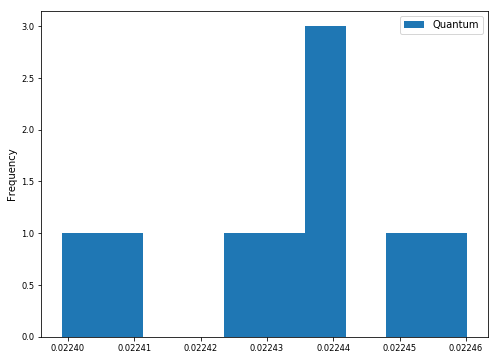

In [176]:
pdf.pct_change().plot(kind='hist', figsize=(8,6), fontsize='small')

In [177]:
# Outputs for trade execution
trading_df = get_trading(220000, consol_px, tickers, opt_env.lookback, alloc, recommend)
pprint.pprint(summary_stats(consol_px, tickers, opt_env.lookback, alloc, recommend, trading_df))
if opt_env.refreshPricing: opt_env.save_recommendation(trading_df)    
trading_df

{'Date': '2018-04-13',
 'Long': 22,
 'Long Exposure': 0.9800044608955035,
 'Net Dollar Exposure': 215582,
 'Positions': 22,
 'Return (Ann)': 0.20015503663324663,
 'Risk (Vol)': 0.0013807125516054012,
 'Sharpe Ratio': 144.965030121961,
 'Short': 0,
 'Short Exposure': 0.0,
 'Total Allocation': 98.00044608955038}


,Company,Price,Allocation,Dollar Value,Shares
AAOI,APPLIED OPTOELECTRONICS INC,30.190001,0.013406,2949,97
ALK,ALASKA AIR GROUP INC,63.950001,0.050000,10999,172
AMC,AMC ENTERTAINMENT HLDS-CL A,16.950001,0.041608,9153,540
AVAV,AEROVIRONMENT INC,56.240002,0.050000,10999,195
AVXS,AVEXIS INC,211.139999,0.035666,7846,37
BGS,B&G FOODS INC,25.200001,0.050000,10999,436
BJRI,BJ'S RESTAURANTS INC,48.750000,0.050000,10999,225
BKD,BROOKDALE SENIOR LIVING INC,6.630000,0.038101,8382,1264
BLCM,BELLICUM PHARMACEUTICALS INC,8.980000,0.050000,10999,1224
CKH,SEACOR HOLDINGS INC,58.750000,0.050000,10999,187
